In [142]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import six
from six.moves import range

In [143]:
from matplotlib import pyplot as plt
%matplotlib inline

In [144]:
X = np.loadtxt('iris.data', dtype='object', delimiter=',')
Y = X[:,-1]
X = X[:, :-1].astype('f')
X.shape, Y.shape, Y.dtype

((150, 4), (150,), dtype('O'))

`X` is a `NxK` float matrix where each row (`X[i]`) corresponds to a data point.

In [145]:
def multivariate_gaussian(X, mean, cov):
    d = X.shape[0]
    left_term = (2*np.pi)**(-d/2)*np.linalg.det(cov)**(-0.5)
    right_term = np.exp(-0.5*np.dot(np.dot((X-mean).T, np.linalg.inv(cov)), X-mean))
    return left_term * right_term

def gmm(X, n_classes, n_iter):
    n, d = X.shape
    
    # Weights (pi)
    pi = np.array([1./ n_classes] *  n_classes)
    # Mean (mu)
    rand_idx = np.random.choice(n, n_classes, replace = False)
    mean = np.array(X[rand_idx, :])
    # Covariance (sigma)
    cov = np.array([np.eye(d)] * n_classes)
    # Responsiblities (gamma)
    res = np.zeros((n, n_classes))
                    
    for _ in range(n_iter):
        # E-Step
        for i in range(n_classes):
            for j in range(n):
                res[j, i] = pi[i] * multivariate_gaussian(X[j], mean[i], cov[i])
        res = (res.T / np.sum(res, axis = 1)).T  # normalize

        # M-Step
        N_K = np.sum(res, axis=0)

        for i in range(n_classes):
            # Update mean
            mean[i] = 1. / N_K[i] * np.sum(res[:, i].reshape(n, 1) * X , axis=0)
            # Update covariance
            cov[i] = (1. / N_K[i]) * np.dot((res[:, i].reshape(n,1) * (X - mean[i]) ).T, X- mean[i])
        # Update weights
        pi = N_K / np.sum(res)
    
    # Pick prediction with largest probability
    class_assignments = np.argmax(res, axis=1)
    return class_assignments, mean, cov

In [146]:
# Hyper parameters
num_classes = 3
num_iteration = 2000

In [147]:
class_assignments, mean, cov = gmm(X, num_classes, num_iteration)  # You may want to tune the number of iterations

## Visualization: a Cross Section

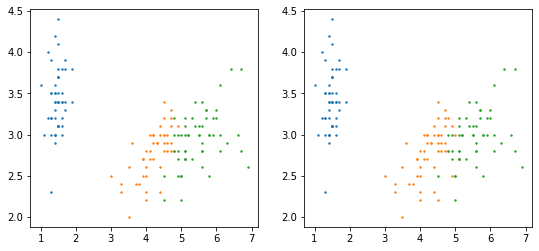

In [148]:
plt.figure(figsize=(9,4))
plt.subplot(121)
for k in range(3):
    plt.scatter(X[class_assignments==k, 2], X[class_assignments==k, 1], s=2)
plt.subplot(122)
for k, class_name in enumerate(np.unique(Y)):
    plt.scatter(X[Y==class_name, 2], X[Y==class_name, 1], s=2)
plt.savefig(f"figures/cs_{num_classes}_{num_iteration}.png")

## Visualization: PCA Projection

In [149]:
evals, evecs = np.linalg.eigh(np.cov(X.T))
to_crd = lambda x: ((x-x.mean(axis=0))@evecs)[:,-2:]
crds = to_crd(X)

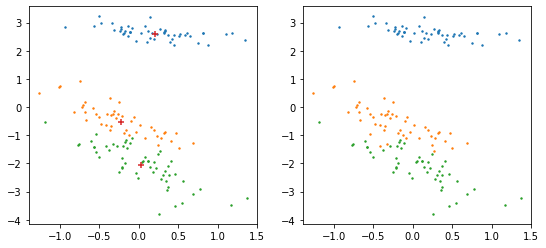

In [150]:
plt.figure(figsize=(9,4))
plt.subplot(121)
for k in range(3):
    plt.scatter(crds[class_assignments==k, 0], crds[class_assignments==k, 1], s=2)
plt.scatter(to_crd(mean)[:,0], to_crd(mean)[:,1], s=30, marker='+')
plt.subplot(122)
for k in np.unique(Y):
    plt.scatter(crds[Y==k, 0], crds[Y==k, 1], s=2)
plt.savefig(f"figures/pca_{num_classes}_{num_iteration}.png")